# Test player-wise Metropolis sampling on all 5,000 matches.

## Setup

In [1]:
import os
import sys

os.chdir("..")

In [2]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import load, munge
import src.models.gp

## Load data.

In [3]:
matches = load.all_matches_df()

In [4]:
matches.shape

(5000, 15)

In [5]:
players_mat = munge.make_match_players_matrix(
    matches.radiant_players, matches.dire_players)
players_mat.shape

(5000, 975)

## Get a list of player IDs.

In [6]:
players = munge.player_id_to_player_name(
    pd.concat([matches.radiant_players, matches.dire_players]),
    pd.concat([matches.radiant_nicknames, matches.dire_nicknames]),
    pd.concat([matches.radiant_valveId, matches.dire_valveId]),
    pd.concat([matches.radiant_name, matches.dire_name]),)

In [7]:
players.loc[players_mat.columns[:5]]

,name,team,team_id
1296625,Newsham,TEAM TEAM,6904594
3916428,EGM,Bald,7237270
3940262,March,Team Jinesbrus,7225724
4281729,syndereN,Anti-MagE-,7247587
5150808,fn,Gambit Esports,6209143


## Run model manually.

In [8]:
two_years_in_ms = 2 * 365 * 24 * 60 * 60 * 1000

In [9]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [10]:
gp = src.models.gp.SkillsGP(players_mat.values,
                            matches.startTimestamp.values,
                            matches.radiantVictory,
                            players_mat.columns.values,
                            "exponential", {"scale": two_years_in_ms},
                            propose_sd=0.2, logistic_scale=5,
                            save_every_n_iter=10)

In [11]:
[gp.samples[0][k] for k in [0, 2, 3]]

[0, 0.0, 139897.44191387721057]

In [12]:
gp.iterate_once_player_wise()

### 100 player-wise iterations.

In [13]:
gp.iterate(100, "playerwise")

100% (100 of 100) |######################| Elapsed Time: 0:00:21 Time:  0:00:21


Text(0.5, 1.0, 'Radiant advantage')

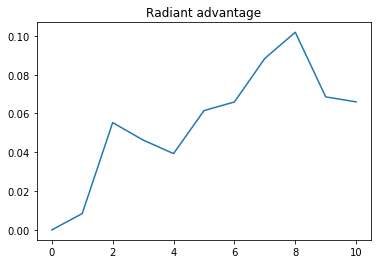

In [14]:
plt.plot([x[2] for x in gp.samples])
plt.title("Radiant advantage")

In [14]:
[[x[0], x[2], x[3]] for x in gp.samples[1:]]

[[10, 0.0015597418153345819, 138572.41010258411642],
 [20, 0.019951506645102934, 137538.75516244577567],
 [30, 0.031074599468974087, 136657.43253249159258],
 [40, 0.04904873917764727, 135881.91096732664377],
 [50, 0.018575390808885484, 135142.98013175932475],
 [60, 0.013663100077579031, 134587.10075912376155],
 [70, -0.01170153106167772, 134036.94979352775842],
 [80, -0.0074103611581453205, 133553.52609170320281],
 [90, -0.019506863972408896, 133125.53787289821945],
 [100, -0.007276011803195007, 132653.29230965712861]]

### 1,000 iterations.

In [15]:
gp.iterate(1000, "playerwise")

100% (1000 of 1000) |####################| Elapsed Time: 0:03:28 Time:  0:03:28


In [16]:
[[x[0], x[2], x[3]] for x in gp.samples[-10:]]

[[1010, 0.226908958860627, 121265.5584766128553],
 [1020, 0.24586046786083204, 121166.40206987689198],
 [1030, 0.27072928506323235, 120954.37997606714061],
 [1040, 0.2738144164321294, 120889.49982738529253],
 [1050, 0.2833744841771382, 120948.6743696609069],
 [1060, 0.29992913631310686, 120871.07049874186519],
 [1070, 0.3003010101987203, 120859.536373510412346],
 [1080, 0.3016807381368854, 120828.697468603139235],
 [1090, 0.30287145410773914, 120829.789190501073016],
 [1100, 0.3351510485615373, 120736.984248961429174]]

Text(0.5, 1.0, 'Radiant advantage')

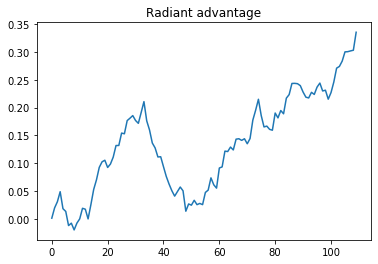

In [17]:
plt.plot([x[2] for x in gp.samples[1:]])
plt.title("Radiant advantage")

In [20]:
src.models.gp.win_prob(0.3, 5)

0.51499550161941

125562.00374660008885

Text(0.5, 1.0, 'log-likelihood')

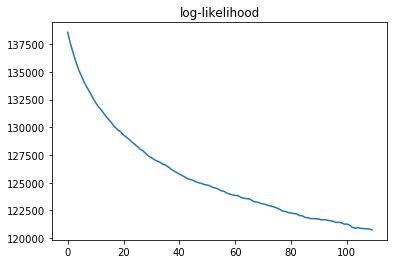

In [21]:
display(np.mean([x[3] for x in gp.samples[1:]]))
plt.plot([x[3] for x in gp.samples[1:]])
plt.title("log-likelihood")

### 10,000 iterations.

In [27]:
gp.iterate(10000, "playerwise")

100% (10000 of 10000) |##################| Elapsed Time: 0:34:47 Time:  0:34:47


In [28]:
[[x[0], x[2], x[3]] for x in gp.samples[-5:]]

[[21060, 0.8787791795357974, 115346.38341610553847],
 [21070, 0.8632451424040757, 115353.15560657389976],
 [21080, 0.8777983916205544, 115308.96026562719643],
 [21090, 0.8555455376933354, 115347.75102886011719],
 [21100, 0.8540379428621014, 115458.92321353435415]]

Text(0.5, 1.0, 'Radiant advantage')

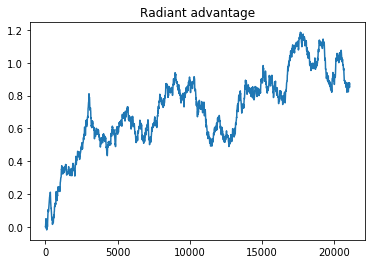

In [29]:
plt.plot([x[0] for x in gp.samples], [x[2] for x in gp.samples])
plt.title("Radiant advantage")

In [30]:
src.models.gp.win_prob(1, 5)

0.549833997312478

Text(0.5, 1.0, 'log-likelihood')

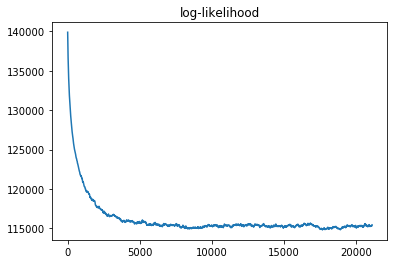

In [31]:
plt.plot([x[0] for x in gp.samples], [x[3] for x in gp.samples])
plt.title("log-likelihood")

In [32]:
with open("fitted_models/gp_all_matches.20190727.dill", 'wb') as fh:
    dill.dump(gp, fh)

## What are skill levels after fitting?

### Check midone.

In [33]:
players.loc[players.name == "MidOne"]

,name,team,team_id
116585378,MidOne,Team Secret,1838315


In [35]:
midone_idx = np.where(gp.player_ids == 116585378)[0][0]
midone_idx

442

In [36]:
def skill_vecs_to_mat(skill_vec_list, player_skill_vecs):
    res = [gp._expand_sparse_player_vec(player_skill_vecs[k][0].transformed(skill_vec_list[k]),
                                        player_skill_vecs[k][1])
           for k in range(len(skill_vec_list))]
    return np.array(res).T

In [37]:
samples = [np.array(skill_vecs_to_mat(x[1], gp.player_skill_vecs))
           for x in gp.samples[-100::10]]

In [38]:
skills = pd.DataFrame(
    np.mean(samples, axis=0),
    columns=pd.MultiIndex.from_arrays(
        [players.loc[players_mat.columns, "team"],
        players.loc[players_mat.columns, "name"]])
)

In [39]:
display(skills.shape)
skills.head()

(5000, 975)

team,TEAM TEAM,Bald,Team Jinesbrus,Anti-MagE-,Gambit Esports,Team Singularity,Forward Gaming,FlyToMoon,Forward Gaming,Team Spirit,...,Taichi Gaming,Alpha Pro,Vega Academy,Pavaga Junior,Winning Gaming,SkrSkr,six eight two,Suicide Team,KG.Luminous,DreamEaters
name,Newsham,EGM,March,syndereN,fn,solen,pieliedie,Yamich,Sneyking,VANSKOR,...,XiaoLaoD1,HokanoTrueStyle,Roflex,Ergon,Z,zr,zipzap,tv/stariy_bog,liyuwang,Sun<3
0,NaN,NaN,NaN,NaN,NaN,NaN,-0.077608,NaN,0.333755,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.074799,NaN,0.344815,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,-0.070241,NaN,0.352372,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,-0.075018,NaN,0.348559,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Skills by player:

In [40]:
skills.mean().sort_values()

team                    name          
LFT                     Scourge McDuck   -1.832472
Bald                    Eixn             -1.551936
FlyToMoon               yoky-            -1.483256
Furia                   mini-`           -1.421886
Midas Club              rZs              -1.337137
EGOBOYS                 Masoku           -1.308182
Furia                   Hyko             -1.297392
Gorillaz-Pride          sl4d1n-          -1.290617
LXG  ESPORTS            bukojuice-       -1.259153
CDEC                    marlin``         -1.254181
Young Drug Gaming       JPfood           -1.240470
INVICTUS GAMING         JT-              -1.229922
Wind and Rain           Qupe             -1.199557
Infamous Young          Rudimental       -1.176991
Thunder Predator        Kotarō Hayama    -1.121119
PG.Barracx              db-              -1.116282
Midas Club              ᅚ                -1.095990
Taichi Gaming           Xyfisbug         -1.088545
CDEC                                     -1

### Skills by team

In [44]:
print(skills.mean().sort_values().reset_index().groupby("team").sum().sort_values(0, ascending=False).to_string())

                                                        0
team                                                     
Team Secret                                      9.516719
Virtus.pro                                       7.796790
PSG.LGD                                          7.786039
Team Liquid                                      7.080889
Evil Geniuses                                    6.572216
Fnatic                                           6.357112
\tVici Gaming                                    6.152366
Forward Gaming                                   5.582938
OG                                               5.444249
Chaos Esports Club                               4.564041
Ninjas in Pyjamas                                4.372911
TNC Predator                                     4.235905
Gambit Esports                                   3.683135
Winstrike Team                                   3.464259
Royal Never Give Up                              3.295740
KEEN GAMING   

In [46]:
src.models.gp.win_prob(9.52 - 1.228, 5)

0.8400231051538408